In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.models import load_model

# Importing data (taking variables type,amount,old balance,new balance,is fraud for the prediction of the fraud)

In [2]:
dataframe= pd.read_csv("../input/paysim1/PS_20174392719_1491204439457_log.csv")
dataframe.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Cleaning and analyzing data


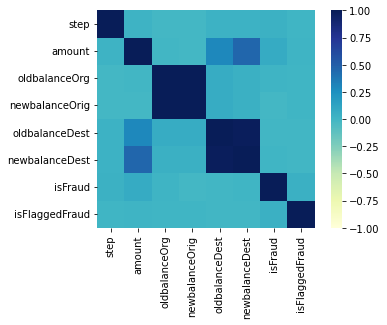

In [3]:

corr=dataframe.corr()
ax=sns.heatmap(corr, vmin=-1, vmax=1, center=0,square=True, cmap='YlGnBu')

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Deleting unwanted Variables

In [5]:
######################################33
# variable shows no corelation to the fraud happening.
del dataframe['nameDest']
del dataframe['nameOrig']
del dataframe['isFlaggedFraud']

In [6]:
dataframe1=dataframe[0:-1]
dataframe1.head(2)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0


In [7]:
cnt0=(dataframe['isFraud']==0).sum()
cnt1=(dataframe['isFraud']==1).sum()

# PreProcessing

In [8]:
le=preprocessing.LabelEncoder()
dataframe1['type2']=le.fit_transform(dataframe1['type'])
del dataframe1['type']
shuffled_df=dataframe1.sample(frac=1,random_state=4)
fraud_df=shuffled_df.loc[shuffled_df['isFraud']==1]
non_fraud_df=shuffled_df.loc[shuffled_df['isFraud']==0].sample(8212,random_state=4)
normalized=pd.concat([fraud_df,non_fraud_df])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
normalized1=normalized.sample(frac=1, random_state=4)
X=normalized1.drop(['isFraud'], axis=1)
Y=normalized1['isFraud']
y3=Y.values.reshape(-1,1)
st_sc = StandardScaler()
X = st_sc.fit_transform(X)
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()
Y1=ohe.fit_transform(y3).toarray()

#############################################################
###       TRAIN TEST SPLIT
###############################################################
from sklearn.model_selection  import train_test_split
x_train, x_test, y_train,y_test=train_test_split(X,Y1, test_size=0.2, random_state=1)

## MODEL CREATION (Using Sequential Model)

In [10]:

model = Sequential()
model.add(Dense(units = 64, input_dim = 7, activation = "relu"))
model.add(Dense(units = 32, activation = "relu"))
model.add(Dense(units = 64, activation = "relu"))
model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(units = 2, activation = "sigmoid"))
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 13,282
Trainable params: 13,282
Non-trainable params: 0
____________________________________________________

2022-05-13 10:16:04.907867: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
model.fit(x_train, y_train, batch_size = 128, epochs = 10, verbose=1)

Epoch 1/10


2022-05-13 10:16:05.134496: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


103/103 [==============================] - 1s 3ms/step - loss: 0.4381 - accuracy: 0.8256
Epoch 2/10
103/103 [==============================] - 0s 3ms/step - loss: 0.2212 - accuracy: 0.9075
Epoch 3/10
103/103 [==============================] - 0s 3ms/step - loss: 0.1702 - accuracy: 0.9310
Epoch 4/10
103/103 [==============================] - 0s 3ms/step - loss: 0.1434 - accuracy: 0.9416
Epoch 5/10
103/103 [==============================] - 0s 3ms/step - loss: 0.1232 - accuracy: 0.9505
Epoch 6/10
103/103 [==============================] - 0s 3ms/step - loss: 0.1323 - accuracy: 0.9516
Epoch 7/10
103/103 [==============================] - 0s 3ms/step - loss: 0.1127 - accuracy: 0.9572
Epoch 8/10
103/103 [==============================] - 0s 3ms/step - loss: 0.1067 - accuracy: 0.9604
Epoch 9/10
103/103 [==============================] - 0s 3ms/step - loss: 0.0960 - accuracy: 0.9648
Epoch 10/10
103/103 [==============================] - 0s 3ms/step - loss: 0.1086 - accuracy: 0.9594


## Model Evaluation


In [12]:
score = model.evaluate(x_test, y_test)
print(score[1])

103/103 [==============================] - 0s 2ms/step - loss: 0.0958 - accuracy: 0.9635
0.9634703397750854


In [13]:
model.save("fraud.md5")

2022-05-13 10:16:10.474374: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
